In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

max : 3.713572
min : 0.000000
Skewness: 1.030917
Kurtosis: -0.204865


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


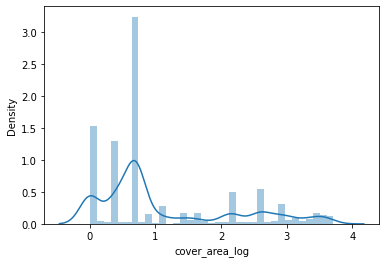

In [10]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [11]:
train["depth_flag"] = 0
train.loc[train["depth"]<=1.0, "depth_flag"] = 1

In [12]:
train["cover_flag"] = 0
train.loc[train["cover_area"]>1, "cover_flag"] = 1

In [13]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [14]:
display(train[features])

,MIN_Datt4,cold_sst,MED_Red_2007,MED_VARIgreen_2007,MED_TIRS2_2005,MAX_EVI_2002,MIN_TIRS2_2013,MED_IR550_2015,MED_CRI550_2014,MIN_SIPI2_2001,...,MIN_IR550_2008,MED_GARI_2013,MAX_Chlgreen_2000,MIN_IF_2009,MAX_NIR_2004,MIN_MCARI2_2005,MIN_B12,MED_Ferrous_Silicates_2016,MIN_Cigreen_2013,MED_AVI_2009
0,12.499782,22.672894,15.025982,-1.683372,8.594291,NaN,7.904585,0.040816,-0.009824,5.704986,...,0.036769,-0.116613,7.108872,2.594846,18.280245,0.384180,16.196962,0.253853,-0.821321,-10.189263
1,3.441133,20.892162,24.828827,1.867548,8.743550,NaN,7.927328,0.021198,-0.002575,4.510093,...,0.025626,-0.007186,NaN,NaN,NaN,0.518160,263.218872,0.182264,-0.848058,NaN
2,4.631280,21.143721,23.942213,14.994102,8.358608,0.080940,7.928771,0.020019,-0.006088,3.741110,...,0.024271,-0.027430,9.965029,2.949804,72.169312,-0.104987,525.379822,0.221319,-0.860894,-23.834005
3,5.876445,20.891870,NaN,NaN,NaN,NaN,7.875004,0.027290,-0.007014,5.619000,...,NaN,-0.159953,NaN,NaN,NaN,NaN,268.322296,0.201644,-0.861408,NaN
4,5.893073,20.883181,NaN,NaN,NaN,NaN,7.883899,0.020757,-0.009219,6.896625,...,NaN,-0.254971,NaN,NaN,NaN,NaN,207.233673,0.221303,-0.866483,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,16.579277,22.716232,20.310654,-2.398487,8.812115,0.079923,6.564856,0.031765,-0.010254,4.868321,...,0.029712,-0.200959,2.961117,2.274326,27.793430,0.296294,223.804779,0.211460,-0.774367,-5.050664
14136,4.766730,20.879339,NaN,NaN,NaN,NaN,7.908076,0.021294,-0.004801,4.037779,...,0.022020,-0.015001,NaN,NaN,NaN,NaN,221.283096,0.231148,-0.898403,NaN
14137,8.252906,22.749920,NaN,NaN,8.594730,NaN,7.912763,0.026361,-0.006571,NaN,...,0.024908,-0.124826,2.619716,2.659188,7.686528,0.944214,40.914101,0.253880,-0.869420,-22.124886
14138,3.123957,20.882458,NaN,NaN,NaN,NaN,7.752955,0.010516,-0.000775,4.388867,...,NaN,0.316531,NaN,NaN,NaN,NaN,219.936935,0.165134,-0.773224,NaN


In [15]:
tr_mesh = train.mesh20.value_counts().index
te_mesh = test.mesh20.value_counts().index

test_only_mesh = list(set(te_mesh)-set(tr_mesh))
test_mesh = list(set(te_mesh)-set(test_only_mesh))

In [16]:
def get_mesh_values(df):
  _df = df["mesh20"].str.split('_').apply(pd.Series).astype(float)
  _df.columns = ["mesh20_left","mesh20_right"]
  df["mesh20_left"] = _df["mesh20_left"].astype(int)
  df["mesh20_right"] = _df["mesh20_right"].astype(int)
  return df

In [17]:
train = get_mesh_values(train)
test = get_mesh_values(test)

In [18]:
tr_mesh_l = train.mesh20_left.value_counts().index
te_mesh_l = test.mesh20_left.value_counts().index

tr_mesh_r = train.mesh20_right.value_counts().index
te_mesh_r = test.mesh20_right.value_counts().index

print(set(te_mesh_l)-set(tr_mesh_l))
print(set(te_mesh_r)-set(tr_mesh_r))

set()
set()


## Model

In [19]:
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [21]:
class CFG:
  ver=14
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="cover_flag"
  target_cols2="cover_area_log"
  boosting_type="gbdt"
  fold_target1="cover_flag"
  fold_target2="cover_area"
  fold_target3="cover_area"

In [22]:
# =========================================================================================
# CV split
# =========================================================================================
target_bins = [-1, .2, .5, .75, 50]
target_bin_name = ['0-0.2', '0.2-0.5', '0.5-0.75', '0.75-']
train["target_bins"] = pd.cut(train["cover_area_log"], bins=target_bins, labels=target_bin_name)
bins_map = {'0-0.2':0,  '0.2-0.5':1, '0.5-0.75':2, '0.75-':3}
train["bins"] = train["target_bins"].map(bins_map)

def get_fold(df,fold_target, isFlag=False, isBinFold=False):
  if isFlag:
    Fold = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    if isBinFold:
      Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
      for n, (train_index, val_index) in enumerate(Fold.split(df, df["bins"], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
    else:
      Fold = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
      for n, (train_index, val_index) in enumerate(Fold.split(df)):
        df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [23]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [24]:
features = list(features)
features.remove('id')
features.remove('area')

In [25]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [26]:
def get_pred(df, test, fold_target, target_cols, model, isF=False, isBinF=False):
  if isF:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True, isBinFold=False)
  else:
    pred_name = ""
    if isBinF:
      train = get_fold(df, fold_target, isFlag=False, isBinFold=True)
    else:
      train = get_fold(df, fold_target, isFlag=False, isBinFold=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              verbose = 200,
              early_stopping_rounds=50)
      
      valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
      test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isF)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isF)
  return oof_df,  test_preds

fold
0    3535
1    3535
2    3535
3    3535
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.204831


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.8779443254817987
Precision Score : 0.9135472370766489
Recall Score 0.8450123660346249
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.204422


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.8793473593817088
Precision Score : 0.9183856502242153
Recall Score 0.8434925864909391
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.200523


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.880275624461671
Precision Score : 0.9223826714801444
Recall Score 0.841845140032949
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.204399


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


F1 Score : 0.8727746417716021
Precision Score : 0.9228650137741047
Recall Score 0.8278418451400329


,feature,importance
2505,sst_ymd,0.011914
2407,hist_warm_sst,0.009375
717,Date_Acquired,0.006641
68,lat,0.006380
3142,depth,0.006055
377,warm_sst,0.005404
2909,fetch,0.004297
1752,month,0.003906
2870,MED_TIRS2_2018,0.003255
2880,MIN_GLI_2014,0.003125


F1 Score : 0.8775971579287329
Precision Score : 0.9192602616147948
Recall Score 0.8395468589083419


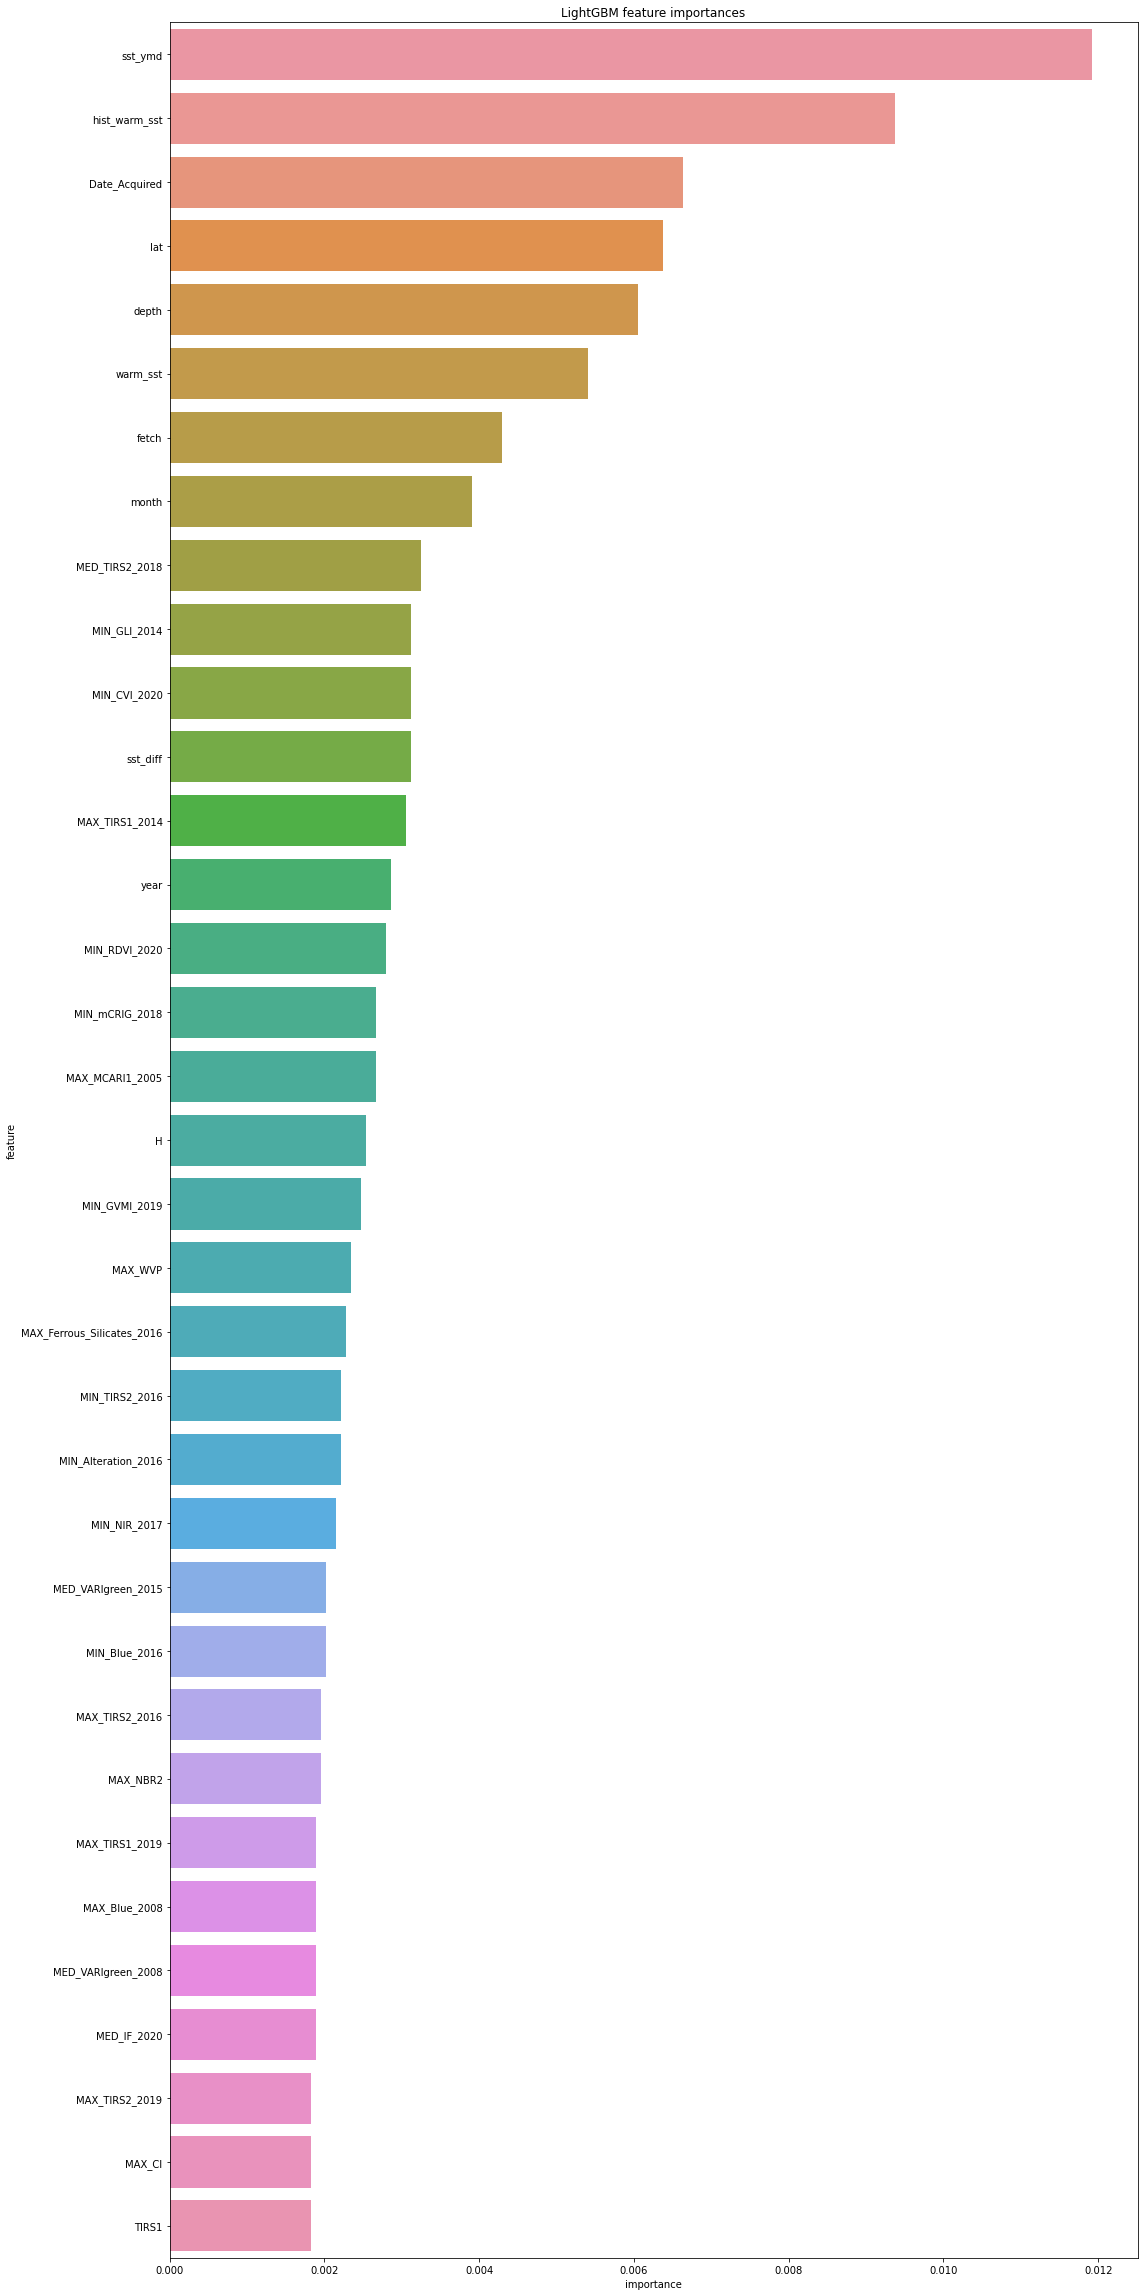

In [27]:
model1 = lgb.LGBMClassifier(**params1)
flag_oof, flag_test_pred = get_pred(train, test, CFG.fold_target1, CFG.target_cols1, model1, isF=True, isBinF=False)

In [28]:
flag_oof["flag_state"] = (flag_oof["flag_pred"]>.5).astype(int)
test["flag_state"] = (np.mean(flag_test_pred, axis=1)>.5).astype(int)

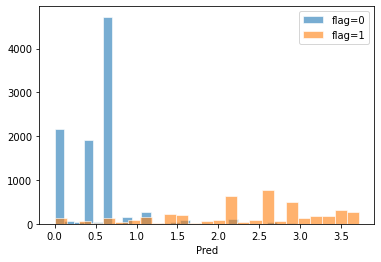

In [29]:
plt.hist(flag_oof.loc[flag_oof.flag_state==0]["cover_area_log"], label='flag=0', bins=25, edgecolor='white', alpha=.6)
plt.hist(flag_oof.loc[flag_oof.flag_state==1]["cover_area_log"], label='flag=1', bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [30]:
big_train = flag_oof.loc[flag_oof.flag_state==1].reset_index(drop=True)
big_test = test.loc[test.flag_state==1]
print(big_train.shape, big_test.shape)

small_train = flag_oof.loc[flag_oof.flag_state==0].reset_index(drop=True)
small_test = test.loc[test.flag_state==0]
print(small_train.shape, small_test.shape)

(4434, 3476) (865, 3467)
(9706, 3476) (3174, 3467)


fold
0    1109
1    1109
2    1108
3    1108
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[115]	valid_0's rmse: 0.528231
RMSE 0.5282311755515219
===============  FOLD : 1  ===============


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.571591
[400]	valid_0's rmse: 0.568962
[600]	valid_0's rmse: 0.568343
Early stopping, best iteration is:
[561]	valid_0's rmse: 0.568343


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.5683429874346493
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.540669
Early stopping, best iteration is:
[227]	valid_0's rmse: 0.540008
RMSE 0.5400083074969605
===============  FOLD : 3  ===============


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.511395
Early stopping, best iteration is:
[345]	valid_0's rmse: 0.509685
RMSE 0.5096853594131756


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


,feature,importance
1752,month,0.010607
2505,sst_ymd,0.006053
2728,sst_diff,0.004821
2217,MAX_CI,0.004768
1269,VARIgreen,0.004419
2292,D678_500,0.004178
784,TIRS1,0.004098
618,GLI,0.003911
406,Ferrous_Silicates,0.003777
321,H,0.003669


RMSE 0.5369946256374231


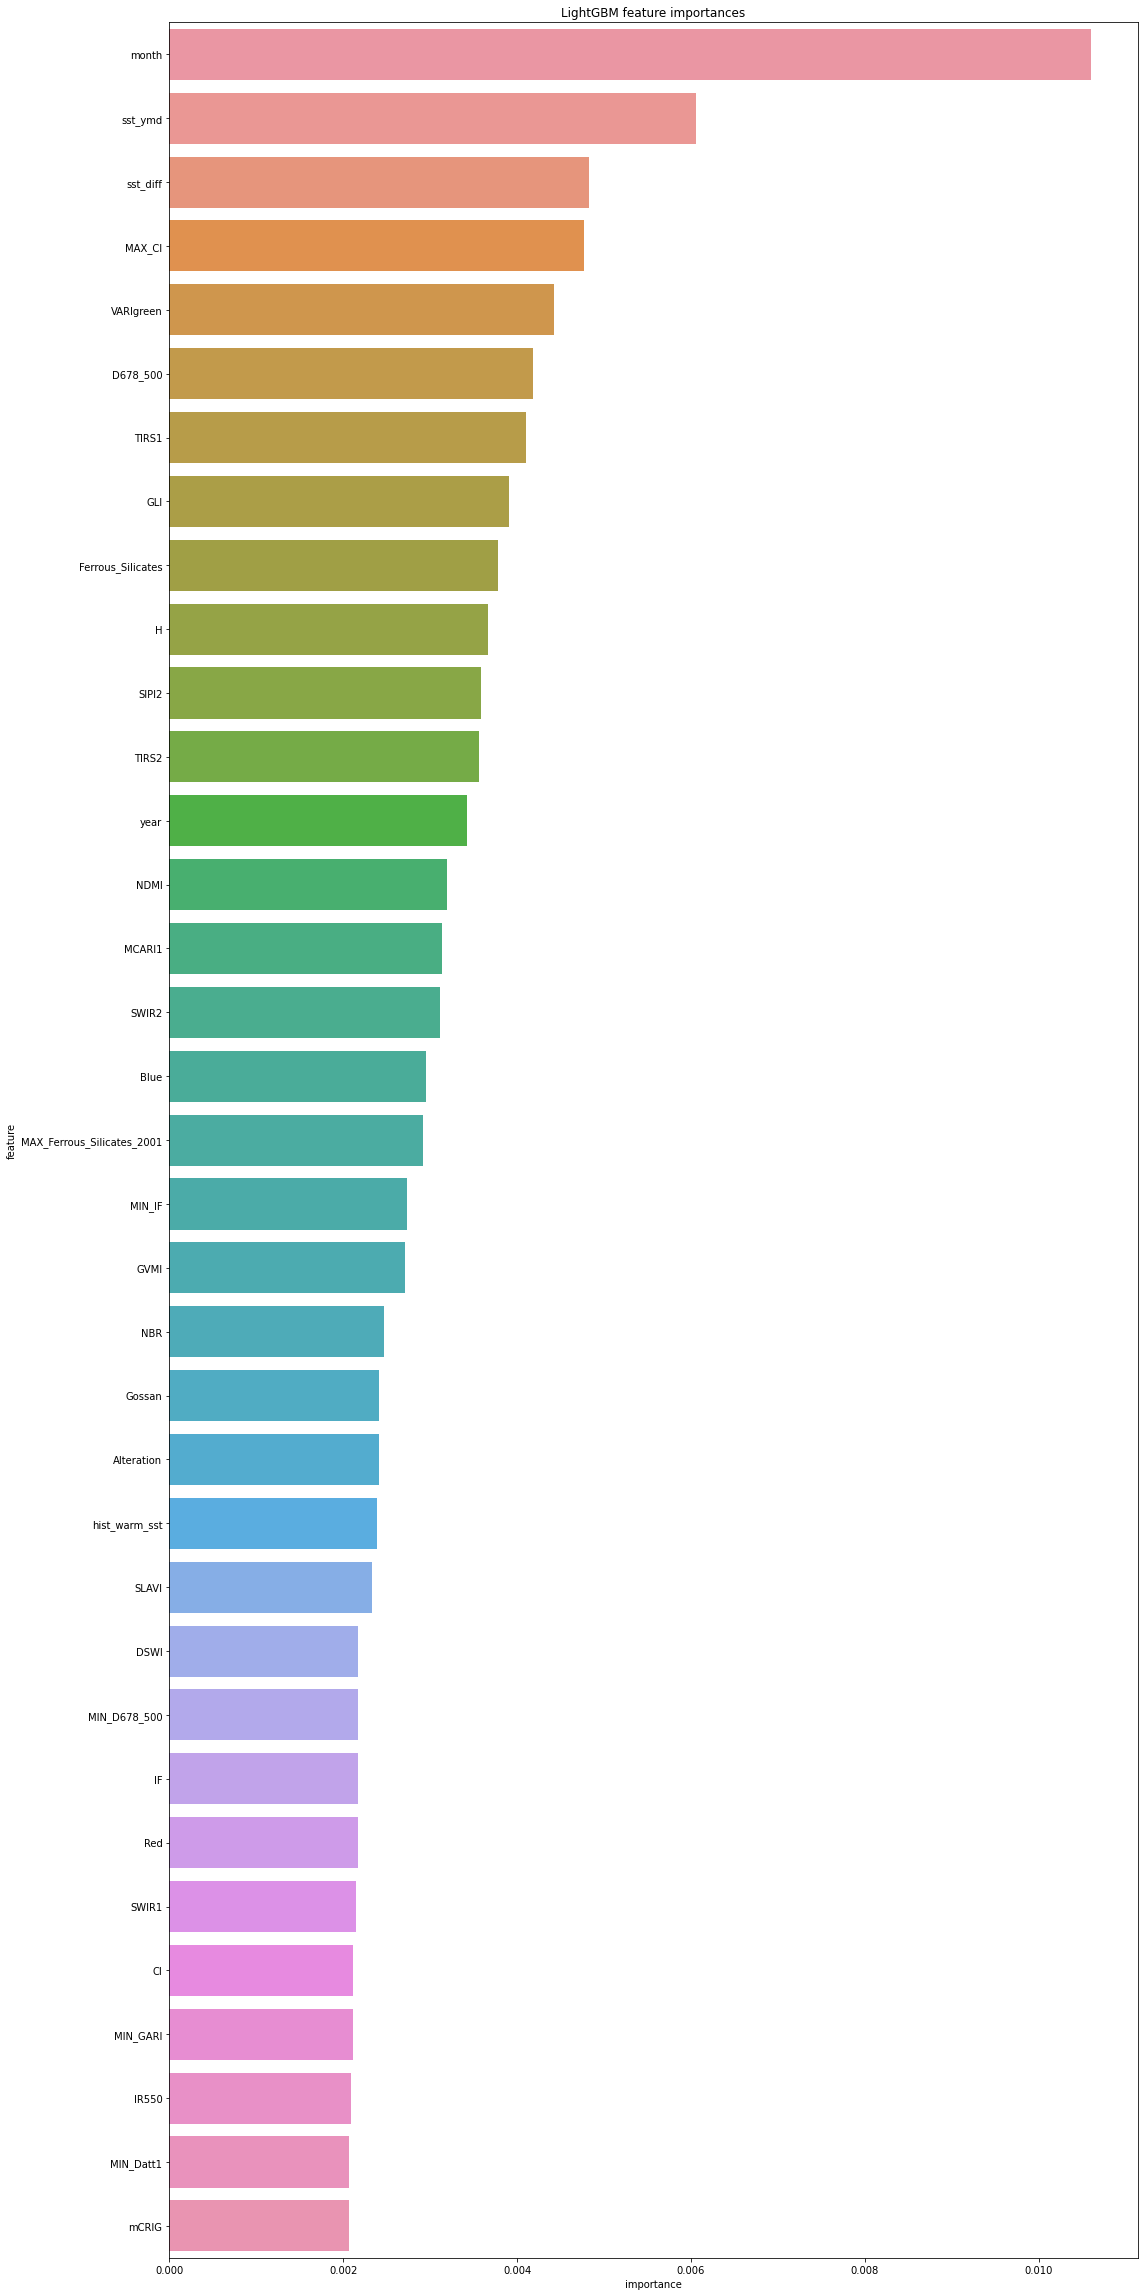

In [31]:
model2 = lgb.LGBMRegressor(**params2)
big_oof, big_test_pred = get_pred(big_train, big_test, CFG.fold_target3, CFG.target_cols2, model2, isF=False, isBinF=False)

fold
0    1794
1    1605
2    2253
3    4054
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.47967
RMSE 0.4796696090783885
===============  FOLD : 1  ===============


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.268879
RMSE 0.26887922748253834

<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)



===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.423991


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.42399117785855706
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.316729


<ipython-input-26-ea0e0a3ba521>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.31672915220329806


,feature,importance
807,year,0.075000
717,Date_Acquired,0.021970
377,warm_sst,0.015909
2909,fetch,0.015152
1317,MIN_AOT,0.009091
1225,MAX_Blue_2016,0.008333
2407,hist_warm_sst,0.007576
516,MAX_TIRS2_2002,0.006818
3112,MIN_IF_2012,0.006061
1403,MIN_RDVI_2013,0.006061


RMSE 0.37163338150595737


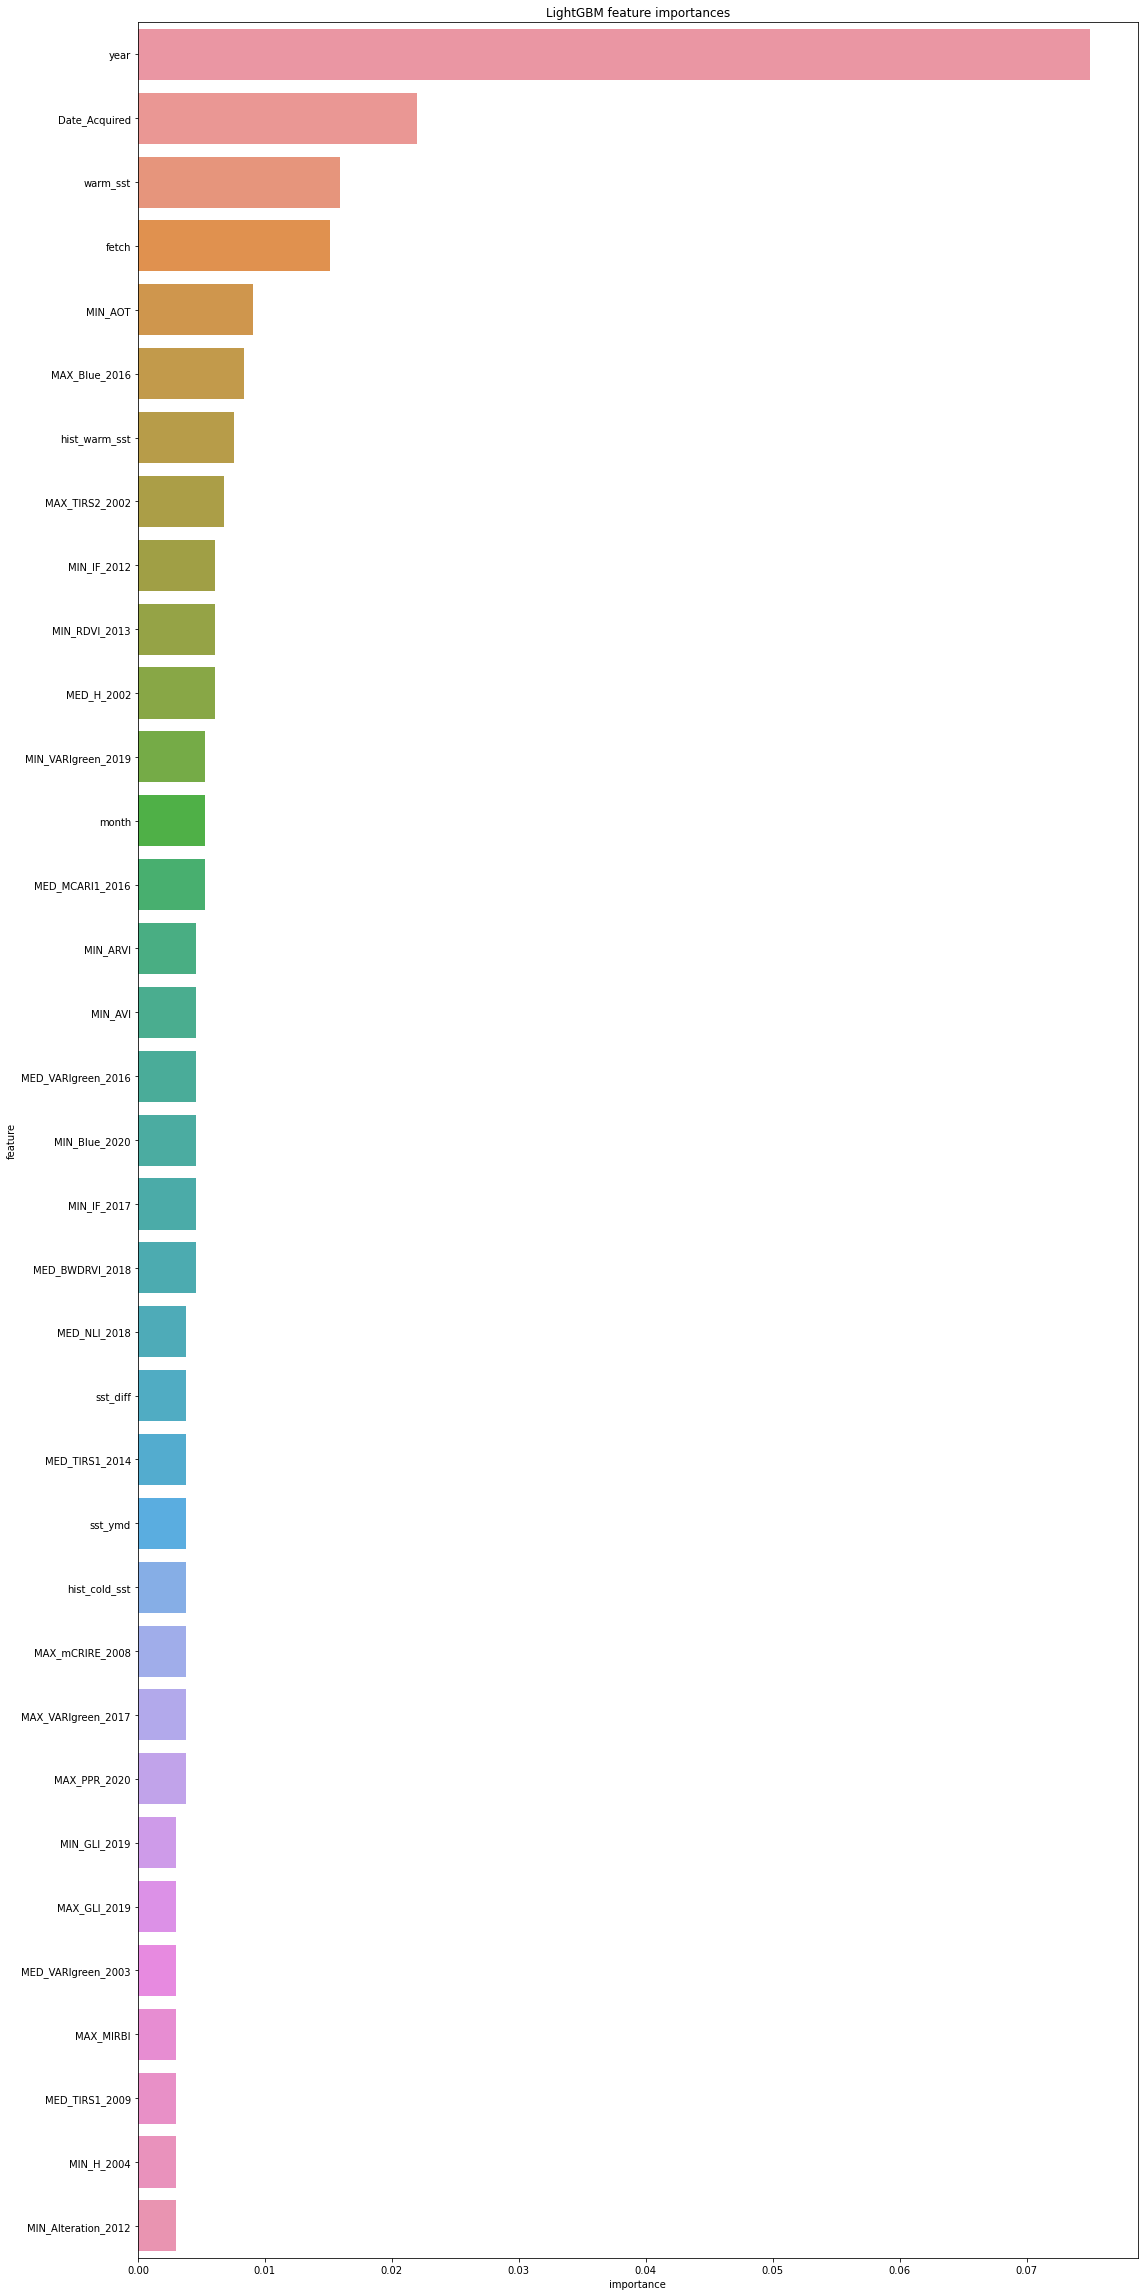

In [32]:
small_oof, small_test_pred = get_pred(small_train, small_test, CFG.fold_target2, CFG.target_cols2, model2, isF=False, isBinF=True)

In [33]:
cover_max = train.cover.max()
_oof = pd.concat([big_oof,small_oof])
_oof["pred"] = np.expm1(_oof["_pred"]) / _oof["area"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.12533879686418778


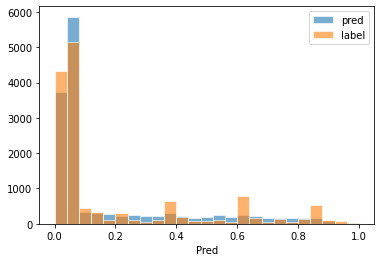

In [34]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [35]:
big_test["pred"] = np.mean(big_test_pred, axis=1)
small_test["pred"] = np.mean(small_test_pred, axis=1)

pred_df = pd.concat([big_test,small_test])
pred_df["pred"] = np.expm1(pred_df["pred"]) / pred_df['area']
pred_df = pred_df.sort_index()
pred_df

<ipython-input-35-d77bd1725607>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_test["pred"] = np.mean(big_test_pred, axis=1)
<ipython-input-35-d77bd1725607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_test["pred"] = np.mean(small_test_pred, axis=1)


,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,mesh20_left,mesh20_right,flag_state,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,3624,20,0,0.032255
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,3624,20,0,0.056489
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,3927,23,0,0.006388
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,3927,11,0,0.048360
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,3725,1,1,0.204582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,4027,3,0,0.028356
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,3624,20,0,0.046140
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,3927,23,0,0.007602
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,3623,3,0,0.048796


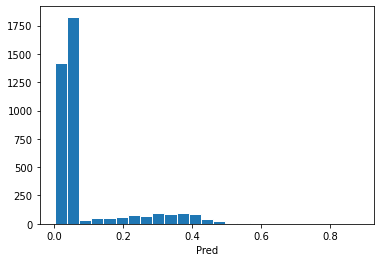

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,mesh20_left,mesh20_right,flag_state,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,3624,20,0,0.032255
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,3624,20,0,0.056489
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,3927,23,0,0.006388
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,3927,11,0,0.048360
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,3725,1,1,0.204582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,4027,3,0,0.028356
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,3624,20,0,0.046140
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,3927,23,0,0.007602
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,3623,3,0,0.048796


In [36]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [37]:
pred_df.pred.max()

0.8832653538528742